In [2]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [3]:
def load_data(file_name): 
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [4]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [5]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [6]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [7]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)


def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [8]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8328
number of edges: 100000
8474 119268


In [9]:
construct_graph_from_edges(valid_edges)
construct_graph_from_edges(false_edges)
construct_graph_from_edges(test_edges)

number of nodes: 5440
number of edges: 19268
number of nodes: 8396
number of edges: 20732
number of nodes: 8509
number of edges: 40000


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [10]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [11]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 '4FXbovgSEFZ5_9S5wddFIg',
 'UG4EKu13JRwzRix6ESINdg',
 'KQMzfaaI9jfo68S4CsCifA',
 '9hMqNBBpTl3lBy6qCAyu-A',
 'EyLVCFOKltmlMg7XcRxU9Q',
 'mM2lXZF7srcZ1FaPx8L7uw',
 'KGsXnYHvYddGaL_jyl0DMQ',
 'QQXTVtCUN-MYpfbau7mm0A',
 'qZB8BZ2ZzMF0VfIGhttu7w']

In [12]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 '3DYOjCqN4u47VV5ZPIeKiA',
 'djP46l4v0TQTqhLa-ZB1xw',
 '04J_q_VhSBItxNiEAN-gkA',
 'Tsm8VraTp5OGyVALtUiCeQ',
 'LIGMK-ewMd4_w6p1u0LBow',
 'O_GWZZfQx7qv-n-CN7hsIA',
 'pJoBzwiaWhtQJ4M64qtXzg',
 'UG4EKu13JRwzRix6ESINdg',
 '4UlC9tI9DmsTgRb9XibrYA']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [13]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 22.9266


In [14]:
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a node2vec model...	number of walks: 83280	average walk length: 9.9910	training time: 22.2838


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [15]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index_to_key.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [-0.08203912 -0.48324758  2.3365617   1.3427093  -0.9593549   0.6891398
  0.5307564   0.6814984  -0.7039322  -0.5113058 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.4264547  -0.4421122   1.6058022   0.92754334 -0.5657387   0.25635484
  1.6026855   0.79032737  0.2628882  -0.6761687 ]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [ 0.04840645 -0.02783736 -1.0780101   0.8456825   0.88846356  1.8893033
  2.9263995   1.148935   -0.28288275 -1.7604916 ]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.8202535
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.1772352


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [16]:
np.random.seed(0)

deepwalk_auc_scores = dict()
for node_dim in [5,10,20,40]:
    for num_walks in [5,10,15,20]:
        for walk_length in [5,10,15,20]:
            print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
            model = build_deepwalk(graph, alias_nodes, 
                                   node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
            deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
            print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))

node dim: 5,	num_walks: 5,	walk_length: 5	building a DeepWalk model...	number of walks: 41640	average walk length: 4.9622	training time: 6.9702
auc: 0.8722
node dim: 5,	num_walks: 5,	walk_length: 10	building a DeepWalk model...	number of walks: 41640	average walk length: 9.8976	training time: 9.3467
auc: 0.9091
node dim: 5,	num_walks: 5,	walk_length: 15	building a DeepWalk model...	number of walks: 41640	average walk length: 14.8335	training time: 12.6175
auc: 0.9139
node dim: 5,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 41640	average walk length: 19.7535	training time: 15.9667
auc: 0.9160
node dim: 5,	num_walks: 10,	walk_length: 5	building a DeepWalk model...	number of walks: 83280	average walk length: 4.9629	training time: 13.9456
auc: 0.9031
node dim: 5,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 19.1609
auc: 0.9167
node dim: 5,	num_walks: 10,	walk_length: 15	building

node dim: 40,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 41640	average walk length: 19.7535	training time: 22.6215
auc: 0.8521
node dim: 40,	num_walks: 10,	walk_length: 5	building a DeepWalk model...	number of walks: 83280	average walk length: 4.9629	training time: 16.6945
auc: 0.8024
node dim: 40,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83280	average walk length: 9.8980	training time: 24.6480
auc: 0.8532
node dim: 40,	num_walks: 10,	walk_length: 15	building a DeepWalk model...	number of walks: 83280	average walk length: 14.8289	training time: 34.2940
auc: 0.8783
node dim: 40,	num_walks: 10,	walk_length: 20	building a DeepWalk model...	number of walks: 83280	average walk length: 19.7559	training time: 42.5061
auc: 0.8887
node dim: 40,	num_walks: 15,	walk_length: 5	building a DeepWalk model...	number of walks: 124920	average walk length: 4.9630	training time: 23.8755
auc: 0.8234
node dim: 40,	num_walks: 15,	walk_lengt

In [18]:
np.random.seed(0)

node_dim = 10
num_walks = 15
walk_length = 15
node2vec_auc_scores = dict()

for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    for q in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
            node_dim, num_walks, walk_length, p, q), end="\t")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                               node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))

node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.10,	q: 0.10	building a node2vec model...	number of walks: 124920	average walk length: 14.9793	training time: 56.6604
auc: 0.9294
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.10,	q: 0.20	building a node2vec model...	number of walks: 124920	average walk length: 14.9818	training time: 50.8219
auc: 0.9288
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.10,	q: 0.30	building a node2vec model...	number of walks: 124920	average walk length: 14.9833	training time: 54.8789
auc: 0.9299
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.10,	q: 0.40	building a node2vec model...	number of walks: 124920	average walk length: 14.9845	training time: 47.5789
auc: 0.9304
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.10,	q: 0.50	building a node2vec model...	number of walks: 124920	average walk length: 14.9839	training time: 47.9688
auc: 0.9301
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.10,	q: 0.60	building a node2vec model...	number o

node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.60,	q: 0.10	building a node2vec model...	number of walks: 124920	average walk length: 14.9600	training time: 56.4314
auc: 0.9287
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.60,	q: 0.20	building a node2vec model...	number of walks: 124920	average walk length: 14.9692	training time: 56.8229
auc: 0.9285
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.60,	q: 0.30	building a node2vec model...	number of walks: 124920	average walk length: 14.9771	training time: 56.1701
auc: 0.9295
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.60,	q: 0.40	building a node2vec model...	number of walks: 124920	average walk length: 14.9790	training time: 55.3206
auc: 0.9299
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.60,	q: 0.50	building a node2vec model...	number of walks: 124920	average walk length: 14.9807	training time: 57.0098
auc: 0.9291
node dim: 10,	num_walks: 15,	walk_length: 15,	p: 0.60,	q: 0.60	building a node2vec model...	number o

Example of using Heatmap to viualize the result.

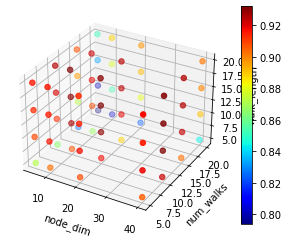

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dw_auc = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for node_dim in [5,10,20,40] for walk_length in [5,10,15,20]] for num_walks in [5,10,15,20]])

x = np.array([5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40])
y = np.array([5,5,5,5,10,10,10,10,15,15,15,15,20,20,20,20,5,5,5,5,10,10,10,10,15,15,15,15,20,20,20,20,5,5,5,5,10,10,10,10,15,15,15,15,20,20,20,20,5,5,5,5,10,10,10,10,15,15,15,15,20,20,20,20])
z = np.array([5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20,5,10,15,20])
c = dw_auc


ax.set_xlabel('node_dim')
ax.set_ylabel('num_walks')
ax.set_zlabel('walk_length')

img = ax.scatter(x, y, z, c=c, s=30, cmap=plt.jet())
fig.colorbar(img)
plt.show()

Text(0, 0.5, 'q')

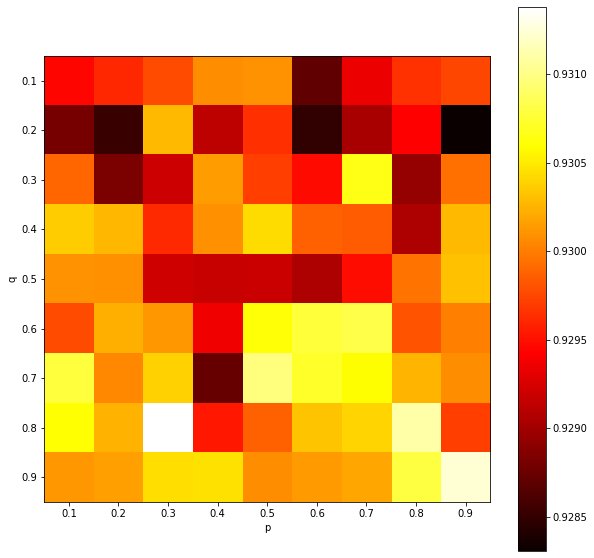

In [27]:
plt.figure(figsize=(10, 10))
node_dim = 10
num_walks = 15
walk_length = 15
# you should have an auc score dictionary here.
a = np.array([[node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]] for q in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.xlabel("p")
plt.yticks(ticks=[0,1,2,3,4,5,6,7,8], labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.ylabel("q")

You can build model with the best parameters you find and save the prediction here.

In [ ]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

DEEPWAK_TUNING

In [ ]:
import optuna
def objective(trial,graph,alias_nodes,alias_edges):
    np.random.seed(0)
    
    node_dim = trial.suggest_categorical("node_dim",[5,10,20,40])
    num_walks = trial.suggest_categorical("num_walks",[5,10,15,20])
    walk_length = trial.suggest_categorical("walk_length",[5,10,15,20])
    deepwalk_auc_scores = dict()

    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
    model = build_deepwalk(graph, alias_nodes, 
                           node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
    deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
    print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))
    return (deepwalk_auc_scores[(node_dim, num_walks, walk_length)])

study = optuna.create_study(direction = 'maximize')
study.optimize(lambda trial:objective(trial,graph=graph,alias_nodes=alias_nodes,alias_edges=alias_edges), n_trials=100)

study.best_params

NODE2VEC TUNING

In [ ]:
def objective_node2vec(trial,graph,alias_nodes,alias_edges):
    np.random.seed(0)
    
    node_dim = trial.suggest_categorical("node_dim",[5,10,20,40])
    num_walks = trial.suggest_categorical("num_walks",[5,10,15,20])
    walk_length = trial.suggest_categorical("walk_length",[5,10,15,20])
    p = trial.suggest_float('p',0.01,1)
    q = trial.suggest_float('q',0.01,1)

    node2vec_auc_scores = dict()
    print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
        node_dim, num_walks, walk_length, p, q), end="\t")
    alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
    model = build_node2vec(graph, alias_nodes, alias_edges, 
                           node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
    node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
    print("auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)]))
    return (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)])

study_node2vec = optuna.create_study(direction = 'maximize')
study_node2vec.optimize(lambda trial:objective_node2vec(trial,graph=graph,alias_nodes=alias_nodes,alias_edges=alias_edges), n_trials=100)

study_node2vec.best_params

use best parameters {'node_dim': 10, 'num_walks': 15, 'walk_length': 15}

In [28]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=15, walk_length=15)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a DeepWalk model...	number of walks: 124920	average walk length: 14.8291	training time: 38.6212


With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.